# Accuracy of diagnostic tests registered by ANVISA for COVID-19

Research: 

Foi conduzida uma pesquisa documental utilizando os dados fornecidos pelos fabricantes no ato do registro na Anvisa. Foram analisados os testes di agnósticos registrados na Anvisa até o dia 23 de junho de 2020, período da coleta de dados, utilizando como ferramenta [esse link](https://consultas.anvisa.gov.br/#/saude/q/?nomeTecnico=coronav%C3%ADrus). 

Os dados informados no ato do registro na Anvisa foram extraídos da página da internet da Agência, da Gerência Geral de Tecnologia de Produtos para Saúde (GGTPS) de diagnóstico in vitro. Para apresentação dos dados, utilizou-se tabela padrão produzida pelos autores, sendo coletados os seguintes dados: i) empresa/importadora; ii) fabricante/país; iii) amostra; iv) se foi considerado como teste rápido v) número de registro na Anvisa; vi) dados
de sensibilidade/especificidade apresentados pelo fabricante. Os dados informados pela indústria na ocasião do registro junto à Anvisa foram utilizados para elaborar gráficos de especificidade e sensibilidade dos testes diagnósticos. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from cmdstanpy import cmdstan_path, CmdStanModel, set_cmdstan_path, install_cmdstan

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import arviz as az
plt.style.use('science')

import sys
import os
sys.path.append('../scripts/python')

from parameter_estimation import BivariateBeta

Os dados fornecidos pelos fabricantes foram plotados nas figuras apresentadas para ilustrar sensibilidade e especificidade IgG e/ou IgM dos testes: 

a) imunocromatográfico com amostra de sangue (sangue total, sangue total venoso, sangue total via punção digital ou sangue seco), soro ou plasma humano; 

b) imunocromatográfico com secreção swab nasofaríngeo e swab orofaríngeo; 

c) imunoensaio com amostra de sangue (sangue total, sangue total venoso, sangue total via punção digital ou sangue seco), soro ou plasma humano; 

d) imunoinsaio com amostra secreção swab nasofaríngeo e swab orofaríngeo; 

e) detecção quali ou semiqualitativa com amostra de sangue

In [27]:
folder = '../data/covid_tests_data/'
filter_func = lambda i: lambda x: float(re.findall('[0-9].[0-9][0-9]', x.replace(',', '.'))[i])

set_cmdstan_path('/home/lucasmoschen/anaconda3/envs/project-beta/bin/cmdstan')

stanfile = os.path.join('..', 'scripts', 'stan', 'bivariate-beta-model-v3-1.stan')
model = CmdStanModel(stan_file=stanfile, cpp_options={'STAN_THREADS': True})

Getting the data

In [25]:
tables = [pd.read_csv(folder+'raw/table_a.csv'),
          pd.read_csv(folder+'raw/table_b.csv'),
          pd.read_csv(folder+'raw/table_c.csv'),
          pd.read_csv(folder+'raw/table_d.csv'),
          pd.read_csv(folder+'raw/table_e.csv'),
          pd.read_csv(folder+'raw/table_pcr_a.csv'),
          pd.read_csv(folder+'raw/table_pcr_b.csv'),
          pd.read_csv(folder+'raw/table_pcr_c.csv'),
         ]

letters = ['a', 'b', 'c', 'd', 'e', 'a_pcr', 'b_pcr', 'c_pcr']
for i in range(8):

    tables[i]['sensitivity']          = tables[i]['Sensitivity [95% CI]'].apply(filter_func(0))
    tables[i]['sensitivity_ci_lower'] = tables[i]['Sensitivity [95% CI]'].apply(filter_func(1))
    tables[i]['sensitivity_ci_upper'] = tables[i]['Sensitivity [95% CI]'].apply(filter_func(2))
    tables[i]['specificity']          = tables[i]['Specificity [95% CI]'].apply(filter_func(0))
    tables[i]['specificity_ci_lower'] = tables[i]['Specificity [95% CI]'].apply(filter_func(1))
    tables[i]['specificity_ci_upper'] = tables[i]['Specificity [95% CI]'].apply(filter_func(2))
    tables[i]['type']                 = letters[i]
    
    del tables[i]['Sensitivity [95% CI]']
    del tables[i]['Specificity [95% CI]']
    
df = pd.concat(tables)

In [26]:
df

,Study,TP,FP,FN,TN,sensitivity,sensitivity_ci_lower,sensitivity_ci_upper,specificity,specificity_ci_lower,specificity_ci_upper,type
0,10071770900,312,1,49,234,0.86,0.82,0.90,1.00,0.98,1.00,a
1,10071770901,46,3,2,47,0.96,0.86,0.99,0.94,0.83,0.99,a
2,10210410105,90,3,3,124,0.97,0.91,0.99,0.98,0.93,1.00,a
3,10310030208,171,12,12,514,0.93,0.89,0.97,0.98,0.96,0.99,a
4,10342880015,23,2,1,49,0.96,0.79,1.00,0.96,0.87,1.00,a
...,...,...,...,...,...,...,...,...,...,...,...,...
11,80867150018,209,10,0,370,1.00,0.98,1.00,0.97,0.95,0.99,a_pcr
12,80954880134,3,0,0,98,1.00,0.29,1.00,1.00,0.96,1.00,a_pcr
0,10009010357,60,0,0,60,1.00,0.94,1.00,1.00,0.94,1.00,b_pcr
1,10223400001,10,0,0,14,1.00,0.69,1.00,1.00,0.77,1.00,b_pcr


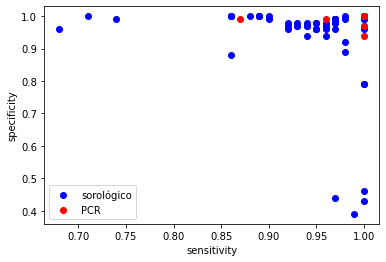

In [4]:
plt.scatter(df[~df.type.str.contains('pcr')].sensitivity, df[~df.type.str.contains('pcr')].specificity,
            color='blue', label='sorológico')
plt.scatter(df[df.type.str.contains('pcr')].sensitivity, df[df.type.str.contains('pcr')].specificity, 
            color='red', label='PCR')
plt.xlabel('sensitivity')
plt.ylabel('specificity')
plt.legend(loc='lower left')
plt.show()

In [5]:
df.describe()

,Study,TP,FP,FN,TN,sensitivity,sensitivity_ci_lower,sensitivity_ci_upper,specificity,specificity_ci_lower,specificity_ci_upper
count,7.100000e+01,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000
mean,5.591396e+10,115.394366,13.971831,7.183099,191.676056,0.946901,0.835070,0.976479,0.942958,0.881127,0.962676
std,3.390722e+10,97.261427,45.681810,11.856656,212.390192,0.065500,0.174076,0.037037,0.132432,0.154064,0.113187
min,1.000901e+10,2.000000,0.000000,0.000000,5.000000,0.680000,0.160000,0.820000,0.390000,0.320000,0.440000
25%,1.034136e+10,49.000000,0.500000,0.000000,60.000000,0.930000,0.820000,0.970000,0.960000,0.890000,0.990000
50%,8.025802e+10,92.000000,2.000000,3.000000,124.000000,0.970000,0.890000,0.990000,0.980000,0.930000,1.000000
75%,8.086715e+10,169.000000,9.000000,7.500000,241.000000,1.000000,0.925000,1.000000,1.000000,0.960000,1.000000
max,8.198451e+10,422.000000,297.000000,49.000000,1364.000000,1.000000,0.980000,1.000000,1.000000,0.990000,1.000000


In [6]:
distribution = BivariateBeta()

x = df.specificity
y = df.sensitivity

m1 = np.mean(x)
m2 = np.mean(y)
v1 = np.var(x, ddof=1)
v2 = np.var(y, ddof=1)
rho = np.corrcoef(x, y)[0,1]

moments = [m1, m2, v1, v2, rho]
moments

[0.9429577464788733,
 0.9469014084507043,
 0.017538269617706236,
 0.0042902615694164975,
 -0.18700410861015324]

In [7]:
alpha_hat1 = distribution.method_moments_estimator_1(x, y)

In [8]:
alpha_hat2 = distribution.method_moments_estimator_2(x, y)

In [9]:
alpha_hat3 = distribution.method_moments_estimator_3(x, y, alpha0=(1,1))

In [10]:
alpha_hat4 = distribution.method_moments_estimator_4(x, y, alpha0=(1,1,1,1))

In [38]:
a = 1*np.ones(4)
b = 1*np.ones(4)

data = {'n': len(x), 'a': a, 'b': b, 'xy': np.column_stack([x,y])}

model_fit = model3.sample(data=data, iter_warmup=2000, iter_sampling=2000, chains=4, adapt_delta=0.9)

21:58:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:58:27 - cmdstanpy - ERROR - CmdStan error: error during processing Operation not permitted


21:58:27 - cmdstanpy - INFO - CmdStan done processing.


RuntimeError: Error during sampling:

Command and output files:
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=1
 cmd (chain 1):
	['/home/lucasmoschen/Documents/github/bivariate-beta/scripts/stan/bivariate-beta-model-v3', 'id=1', 'random', 'seed=35241', 'data', 'file=/tmp/tmp6rnm1eix/9jz_740w.json', 'output', 'file=/tmp/tmp6rnm1eix/bivariate-beta-model-v3zpqzrf5_/bivariate-beta-model-v3-20220930215827.csv', 'method=sample', 'num_samples=2000', 'num_warmup=2000', 'algorithm=hmc', 'adapt', 'engaged=1', 'delta=0.9', 'num_chains=4']
 retcodes=[1]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp6rnm1eix/bivariate-beta-model-v3zpqzrf5_/bivariate-beta-model-v3-20220930215827_1.csv
 console_msgs (if any):
	/tmp/tmp6rnm1eix/bivariate-beta-model-v3zpqzrf5_/bivariate-beta-model-v3-20220930215827-stdout.txt
Consider re-running with show_console=True if the above output is unclear!

In [46]:
distribution.positive_diagnostic_diagnostic(x,y)

-0.006696133857051478

# Characteristics of Lymphangiography Studies Included in Meta-analysis

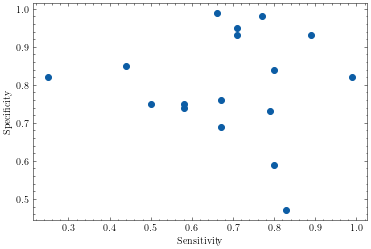

In [4]:
studies = pd.read_csv('../data/study_lymphangeiography.csv')
studies.Sensitivity = studies.Sensitivity/100
studies.Specificity = studies.Specificity/100
studies.loc[16, 'Sensitivity'] = 0.99
x = studies.Sensitivity
y = studies.Specificity
plt.scatter(x, y)
plt.xlabel('Sensitivity')
plt.ylabel('Specificity')
plt.show()

In [6]:
studies['N'].sum()

1408

In [7]:
BivariateBeta().marginal_diagnostic(x,y)

(-0.3985932358748122, 0.6901929464561363)

In [8]:
BivariateBeta().positive_diagnostic_diagnostic(x,y)

0.05276871867476314

In [9]:
BivariateBeta().method_moments_estimator_1(x,y)

array([3.10919065, 0.85604532, 1.52032454, 0.30559168])

In [10]:
np.corrcoef(studies.Sensitivity, studies.Specificity)

array([[ 1.        , -0.05630277],
       [-0.05630277,  1.        ]])

In [63]:
a = 1*np.ones(4)
b = 1*np.ones(4)

data = {'n': len(x), 'a': a, 'b': b, 'xy': np.column_stack([x,y]), 'w': len(x)*studies.N/studies.N.sum()}

model_fit = model.sample(data=data, iter_warmup=2000, iter_sampling=2000, chains=4, adapt_delta=0.9)

17:37:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:38:06 - cmdstanpy - INFO - CmdStan done processing.
17:38:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable[1] is 0, but must be positive finite! (in '/home/lucasmoschen/Documents/github/bivariate-beta/scripts/stan/bivariate-beta-model-v3-1.stan', line 41, column 4 to column 24)
	Exception: gamma_lpdf: Random variable[1] is inf, but must be positive finite! (in '/home/lucasmoschen/Documents/github/bivariate-beta/scripts/stan/bivariate-beta-model-v3-1.stan', line 41, column 4 to column 24)
	Exception: gamma_lpdf: Random variable[2] is inf, but must be positive finite! (in '/home/lucasmoschen/Documents/github/bivariate-beta/scripts/stan/bivariate-beta-model-v3-1.stan', line 41, column 4 to column 24)
Consider re-running with show_console=True if the above output is unclear!
17:38:06 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1357 divergent transitions (67.8%)
	Chain 1 had 643 iterations at max treedept

In [60]:
print(model_fit.diagnose())

Processing csv files: /tmp/tmp6xsrwild/bivariate-beta-model-v3-1plk_s2sn/bivariate-beta-model-v3-1-20221006173026_1.csv, /tmp/tmp6xsrwild/bivariate-beta-model-v3-1plk_s2sn/bivariate-beta-model-v3-1-20221006173026_2.csv, /tmp/tmp6xsrwild/bivariate-beta-model-v3-1plk_s2sn/bivariate-beta-model-v3-1-20221006173026_3.csv, /tmp/tmp6xsrwild/bivariate-beta-model-v3-1plk_s2sn/bivariate-beta-model-v3-1-20221006173026_4.csv

Checking sampler transitions treedepth.
6389 of 8000 (79.86%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
1611 of 8000 (20.14%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparam

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>]], dtype=object)

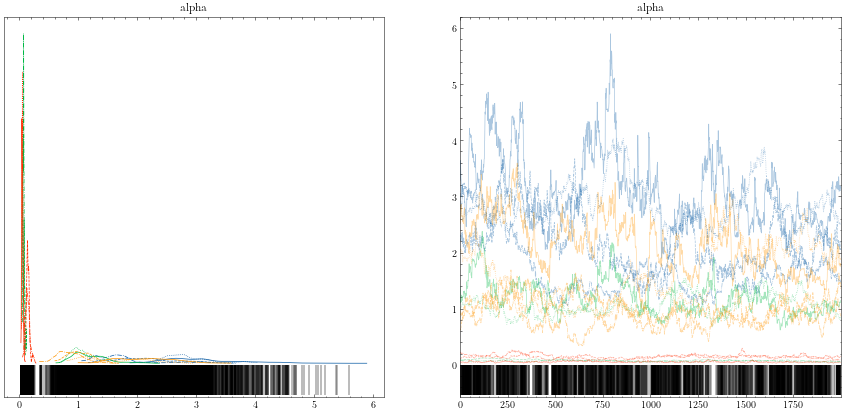

In [61]:
az.plot_trace(model_fit, var_names=['alpha'], figsize=(15,7))

In [62]:
model_fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,1.293270e+02,8.915170,1.301630e+01,1.119890e+02,1.267780e+02,1.460040e+02,2.13166,0.039426,4.388620e+00
alpha[1],2.465180e+00,0.405205,7.698780e-01,1.305010e+00,2.522100e+00,3.825530e+00,3.60989,0.066766,1.626070e+00
alpha[2],6.012950e-01,0.376628,5.572310e-01,5.503340e-02,6.209260e-01,1.459190e+00,2.18900,0.040486,3.942620e+00
alpha[3],1.404900e+00,0.367708,6.365960e-01,6.523090e-01,1.182460e+00,2.624420e+00,2.99724,0.055435,1.995530e+00
alpha[4],9.942970e-02,0.032080,5.143200e-02,4.011440e-02,8.312020e-02,1.823910e-01,2.57035,0.047539,2.205470e+00
u_raw[1],5.000000e-01,0.007906,5.000310e-01,1.100000e-14,1.000000e+00,1.000000e+00,4000.00000,73.980900,4.582245e+09
u_raw[2],3.890040e-01,0.028511,2.422610e-01,2.680640e-02,3.855120e-01,8.283520e-01,72.20150,1.335380,1.049380e+00
u_raw[3],5.030520e-01,0.351227,4.974250e-01,1.781850e-06,9.999980e-01,1.000000e+00,2.00576,0.037097,2.601510e+01
u_raw[4],4.120520e-01,0.055396,3.142820e-01,5.996070e-03,3.668340e-01,9.256930e-01,32.18660,0.595298,1.194450e+00
u_raw[5],5.000000e-01,0.007906,5.000310e-01,3.000000e-16,1.000000e+00,1.000000e+00,4000.00000,73.980900,4.101785e+15
